## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('INTC.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
...,...,...,...,...,...,...,...
1114,2023-06-06,29.770000,31.450001,29.700001,30.959999,30.959999,42295300
1115,2023-06-07,31.030001,31.370001,30.930000,31.280001,31.280001,39098000
1116,2023-06-08,31.430000,31.850000,31.059999,31.820000,31.820000,35199000
1117,2023-06-09,31.930000,31.990000,30.680000,31.340000,31.340000,40218000


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 6:2:2
train_size = int(len(data_scaled) * 0.6)
val_size = int(len(data_scaled) * 0.2)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [12]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [13]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  val_last_windowsize = val_data[-window_size:]
  test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

  train_windows, train_targets = create_dataset(train_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)
  test_windows, test_targets = create_dataset(test_data_extended, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [14]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-17 01:23:15,928] A new study created in memory with name: no-name-dea391ca-7ae8-4d3c-a988-3028d2841245


8/8 [==============================] - 1s 8ms/step


[I 2023-06-17 01:23:31,241] Trial 0 finished with value: 30.27921853792397 and parameters: {'window_size': 31, 'tcn_filters': 70, 'tcn_kernel_size': 5, 'dropout_rate': 0.3493115720023663, 'attention_dim': 15}. Best is trial 0 with value: 30.27921853792397.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:23:39,611] Trial 1 finished with value: 65.82594049112322 and parameters: {'window_size': 16, 'tcn_filters': 50, 'tcn_kernel_size': 4, 'dropout_rate': 0.43044063793612264, 'attention_dim': 29}. Best is trial 0 with value: 30.27921853792397.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:23:49,109] Trial 2 finished with value: 66.64753048738656 and parameters: {'window_size': 44, 'tcn_filters': 50, 'tcn_kernel_size': 5, 'dropout_rate': 0.3142572024043999, 'attention_dim': 26}. Best is trial 0 with value: 30.27921853792397.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:23:57,721] Trial 3 finished with value: 35.323761930242455 and parameters: {'window_size': 16, 'tcn_filters': 108, 'tcn_kernel_size': 4, 'dropout_rate': 0.34706826817530256, 'attention_dim': 17}. Best is trial 0 with value: 30.27921853792397.


8/8 [==============================] - 0s 11ms/step


[I 2023-06-17 01:24:18,626] Trial 4 finished with value: 23.669169432510376 and parameters: {'window_size': 78, 'tcn_filters': 123, 'tcn_kernel_size': 5, 'dropout_rate': 0.3533211979556231, 'attention_dim': 13}. Best is trial 4 with value: 23.669169432510376.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:24:30,221] Trial 5 finished with value: 57.360173779561045 and parameters: {'window_size': 42, 'tcn_filters': 106, 'tcn_kernel_size': 3, 'dropout_rate': 0.4627040515200982, 'attention_dim': 31}. Best is trial 4 with value: 23.669169432510376.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:24:42,328] Trial 6 finished with value: 89.53222625273858 and parameters: {'window_size': 86, 'tcn_filters': 52, 'tcn_kernel_size': 4, 'dropout_rate': 0.4793936367519336, 'attention_dim': 24}. Best is trial 4 with value: 23.669169432510376.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:24:53,800] Trial 7 finished with value: 41.70577568512461 and parameters: {'window_size': 95, 'tcn_filters': 72, 'tcn_kernel_size': 4, 'dropout_rate': 0.43170114861566733, 'attention_dim': 16}. Best is trial 4 with value: 23.669169432510376.


8/8 [==============================] - 0s 19ms/step


[I 2023-06-17 01:25:16,894] Trial 8 finished with value: 38.744573349392624 and parameters: {'window_size': 87, 'tcn_filters': 128, 'tcn_kernel_size': 5, 'dropout_rate': 0.34594575270703265, 'attention_dim': 22}. Best is trial 4 with value: 23.669169432510376.


8/8 [==============================] - 0s 12ms/step


[I 2023-06-17 01:25:33,040] Trial 9 finished with value: 23.982063386053426 and parameters: {'window_size': 76, 'tcn_filters': 88, 'tcn_kernel_size': 5, 'dropout_rate': 0.2754739833330946, 'attention_dim': 15}. Best is trial 4 with value: 23.669169432510376.


8/8 [==============================] - 0s 11ms/step


[I 2023-06-17 01:25:45,983] Trial 10 finished with value: 17.062490625774117 and parameters: {'window_size': 66, 'tcn_filters': 124, 'tcn_kernel_size': 2, 'dropout_rate': 0.16179557274217193, 'attention_dim': 9}. Best is trial 10 with value: 17.062490625774117.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:25:58,881] Trial 11 finished with value: 21.453401840306615 and parameters: {'window_size': 67, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.1386492380517726, 'attention_dim': 8}. Best is trial 10 with value: 17.062490625774117.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:26:12,428] Trial 12 finished with value: 13.461845361894868 and parameters: {'window_size': 62, 'tcn_filters': 109, 'tcn_kernel_size': 2, 'dropout_rate': 0.12581668166507756, 'attention_dim': 8}. Best is trial 12 with value: 13.461845361894868.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:26:24,912] Trial 13 finished with value: 12.255525635111995 and parameters: {'window_size': 58, 'tcn_filters': 105, 'tcn_kernel_size': 2, 'dropout_rate': 0.10288204112888172, 'attention_dim': 8}. Best is trial 13 with value: 12.255525635111995.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:26:37,102] Trial 14 finished with value: 10.006244191461992 and parameters: {'window_size': 51, 'tcn_filters': 98, 'tcn_kernel_size': 2, 'dropout_rate': 0.10914337274749114, 'attention_dim': 11}. Best is trial 14 with value: 10.006244191461992.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:26:49,247] Trial 15 finished with value: 9.254544663222509 and parameters: {'window_size': 50, 'tcn_filters': 91, 'tcn_kernel_size': 3, 'dropout_rate': 0.1037062121846968, 'attention_dim': 12}. Best is trial 15 with value: 9.254544663222509.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:27:01,388] Trial 16 finished with value: 32.99677988985026 and parameters: {'window_size': 45, 'tcn_filters': 88, 'tcn_kernel_size': 3, 'dropout_rate': 0.18029046395611342, 'attention_dim': 12}. Best is trial 15 with value: 9.254544663222509.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:27:04,485] Trial 17 finished with value: 72.8353706731356 and parameters: {'window_size': 31, 'tcn_filters': 32, 'tcn_kernel_size': 3, 'dropout_rate': 0.20016000218763152, 'attention_dim': 19}. Best is trial 15 with value: 9.254544663222509.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:27:16,683] Trial 18 finished with value: 8.31713616749879 and parameters: {'window_size': 51, 'tcn_filters': 94, 'tcn_kernel_size': 3, 'dropout_rate': 0.10320873795480628, 'attention_dim': 12}. Best is trial 18 with value: 8.31713616749879.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:27:28,863] Trial 19 finished with value: 16.634924982488748 and parameters: {'window_size': 29, 'tcn_filters': 82, 'tcn_kernel_size': 3, 'dropout_rate': 0.2122738352256472, 'attention_dim': 19}. Best is trial 18 with value: 8.31713616749879.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:27:41,794] Trial 20 finished with value: 44.57189839538987 and parameters: {'window_size': 53, 'tcn_filters': 65, 'tcn_kernel_size': 3, 'dropout_rate': 0.23912781484675436, 'attention_dim': 13}. Best is trial 18 with value: 8.31713616749879.


8/8 [==============================] - 0s 10ms/step


[I 2023-06-17 01:27:54,290] Trial 21 finished with value: 17.89465710373952 and parameters: {'window_size': 52, 'tcn_filters': 94, 'tcn_kernel_size': 2, 'dropout_rate': 0.1050084841942752, 'attention_dim': 11}. Best is trial 18 with value: 8.31713616749879.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:28:07,312] Trial 22 finished with value: 13.202776052717725 and parameters: {'window_size': 39, 'tcn_filters': 97, 'tcn_kernel_size': 3, 'dropout_rate': 0.1454277677077724, 'attention_dim': 11}. Best is trial 18 with value: 8.31713616749879.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:28:19,991] Trial 23 finished with value: 29.41026568867018 and parameters: {'window_size': 49, 'tcn_filters': 98, 'tcn_kernel_size': 2, 'dropout_rate': 0.16489905566277296, 'attention_dim': 10}. Best is trial 18 with value: 8.31713616749879.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:28:32,141] Trial 24 finished with value: 7.493967399908384 and parameters: {'window_size': 36, 'tcn_filters': 117, 'tcn_kernel_size': 3, 'dropout_rate': 0.10814284842325915, 'attention_dim': 14}. Best is trial 24 with value: 7.493967399908384.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:28:38,632] Trial 25 finished with value: 8.502712724629378 and parameters: {'window_size': 27, 'tcn_filters': 114, 'tcn_kernel_size': 3, 'dropout_rate': 0.13292739414068283, 'attention_dim': 14}. Best is trial 24 with value: 7.493967399908384.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:28:48,599] Trial 26 finished with value: 8.287544470429166 and parameters: {'window_size': 23, 'tcn_filters': 116, 'tcn_kernel_size': 3, 'dropout_rate': 0.146788394270864, 'attention_dim': 17}. Best is trial 24 with value: 7.493967399908384.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:29:00,784] Trial 27 finished with value: 10.533677645647998 and parameters: {'window_size': 10, 'tcn_filters': 116, 'tcn_kernel_size': 4, 'dropout_rate': 0.16570690718212744, 'attention_dim': 17}. Best is trial 24 with value: 7.493967399908384.


8/8 [==============================] - 1s 5ms/step


[I 2023-06-17 01:29:13,591] Trial 28 finished with value: 16.091910269185917 and parameters: {'window_size': 22, 'tcn_filters': 116, 'tcn_kernel_size': 3, 'dropout_rate': 0.20165961459873466, 'attention_dim': 20}. Best is trial 24 with value: 7.493967399908384.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:29:25,907] Trial 29 finished with value: 9.13437919760302 and parameters: {'window_size': 36, 'tcn_filters': 77, 'tcn_kernel_size': 4, 'dropout_rate': 0.14191549552732685, 'attention_dim': 22}. Best is trial 24 with value: 7.493967399908384.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:29:39,588] Trial 30 finished with value: 20.695980573087354 and parameters: {'window_size': 35, 'tcn_filters': 119, 'tcn_kernel_size': 3, 'dropout_rate': 0.1827123164406676, 'attention_dim': 15}. Best is trial 24 with value: 7.493967399908384.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:29:45,879] Trial 31 finished with value: 5.600099903635085 and parameters: {'window_size': 25, 'tcn_filters': 114, 'tcn_kernel_size': 3, 'dropout_rate': 0.13175479750070856, 'attention_dim': 14}. Best is trial 31 with value: 5.600099903635085.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:29:53,936] Trial 32 finished with value: 8.821160008725705 and parameters: {'window_size': 22, 'tcn_filters': 104, 'tcn_kernel_size': 3, 'dropout_rate': 0.12666372566802978, 'attention_dim': 17}. Best is trial 31 with value: 5.600099903635085.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:30:02,311] Trial 33 finished with value: 8.28370451946223 and parameters: {'window_size': 24, 'tcn_filters': 111, 'tcn_kernel_size': 3, 'dropout_rate': 0.15308457050189944, 'attention_dim': 14}. Best is trial 31 with value: 5.600099903635085.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:30:15,103] Trial 34 finished with value: 18.897529140000973 and parameters: {'window_size': 21, 'tcn_filters': 111, 'tcn_kernel_size': 3, 'dropout_rate': 0.15404749866507955, 'attention_dim': 18}. Best is trial 31 with value: 5.600099903635085.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:30:27,237] Trial 35 finished with value: 22.818985289623395 and parameters: {'window_size': 10, 'tcn_filters': 121, 'tcn_kernel_size': 4, 'dropout_rate': 0.23331451147037274, 'attention_dim': 15}. Best is trial 31 with value: 5.600099903635085.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:30:32,486] Trial 36 finished with value: 5.302183996812009 and parameters: {'window_size': 15, 'tcn_filters': 102, 'tcn_kernel_size': 4, 'dropout_rate': 0.1812897759013061, 'attention_dim': 14}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:30:45,994] Trial 37 finished with value: 15.002957334514019 and parameters: {'window_size': 16, 'tcn_filters': 101, 'tcn_kernel_size': 4, 'dropout_rate': 0.18210879398060148, 'attention_dim': 28}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:30:56,139] Trial 38 finished with value: 12.565806126506006 and parameters: {'window_size': 16, 'tcn_filters': 110, 'tcn_kernel_size': 4, 'dropout_rate': 0.1302860361417965, 'attention_dim': 14}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:31:07,036] Trial 39 finished with value: 11.906168265012493 and parameters: {'window_size': 26, 'tcn_filters': 123, 'tcn_kernel_size': 4, 'dropout_rate': 0.17582277092465873, 'attention_dim': 22}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 01:31:22,504] Trial 40 finished with value: 14.733955082159182 and parameters: {'window_size': 33, 'tcn_filters': 105, 'tcn_kernel_size': 5, 'dropout_rate': 0.15618688326682884, 'attention_dim': 14}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:31:34,667] Trial 41 finished with value: 8.456364306401257 and parameters: {'window_size': 21, 'tcn_filters': 114, 'tcn_kernel_size': 3, 'dropout_rate': 0.12376239014787996, 'attention_dim': 16}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 01:31:46,962] Trial 42 finished with value: 20.06736223851596 and parameters: {'window_size': 25, 'tcn_filters': 118, 'tcn_kernel_size': 3, 'dropout_rate': 0.14965095875851622, 'attention_dim': 18}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:31:53,961] Trial 43 finished with value: 11.59645309414025 and parameters: {'window_size': 14, 'tcn_filters': 125, 'tcn_kernel_size': 3, 'dropout_rate': 0.15269544425331177, 'attention_dim': 16}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:32:07,241] Trial 44 finished with value: 10.726690515515644 and parameters: {'window_size': 40, 'tcn_filters': 110, 'tcn_kernel_size': 4, 'dropout_rate': 0.12564642479146043, 'attention_dim': 13}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:32:15,242] Trial 45 finished with value: 7.912067630129874 and parameters: {'window_size': 16, 'tcn_filters': 103, 'tcn_kernel_size': 3, 'dropout_rate': 0.11888601601708314, 'attention_dim': 16}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:32:22,492] Trial 46 finished with value: 12.231303668111181 and parameters: {'window_size': 18, 'tcn_filters': 102, 'tcn_kernel_size': 4, 'dropout_rate': 0.11658569822403339, 'attention_dim': 10}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:32:34,730] Trial 47 finished with value: 12.53332344249057 and parameters: {'window_size': 12, 'tcn_filters': 83, 'tcn_kernel_size': 3, 'dropout_rate': 0.11849813013605207, 'attention_dim': 14}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 01:32:41,976] Trial 48 finished with value: 8.580978222021512 and parameters: {'window_size': 19, 'tcn_filters': 65, 'tcn_kernel_size': 4, 'dropout_rate': 0.13667112858966843, 'attention_dim': 20}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:32:53,475] Trial 49 finished with value: 11.440721436312137 and parameters: {'window_size': 28, 'tcn_filters': 109, 'tcn_kernel_size': 2, 'dropout_rate': 0.16850783360051105, 'attention_dim': 32}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:33:16,648] Trial 50 finished with value: 23.204081790568292 and parameters: {'window_size': 44, 'tcn_filters': 101, 'tcn_kernel_size': 3, 'dropout_rate': 0.1031319460736865, 'attention_dim': 15}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:33:29,258] Trial 51 finished with value: 34.35937744911946 and parameters: {'window_size': 25, 'tcn_filters': 112, 'tcn_kernel_size': 3, 'dropout_rate': 0.14640871521212415, 'attention_dim': 16}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:33:39,988] Trial 52 finished with value: 11.409014257768781 and parameters: {'window_size': 32, 'tcn_filters': 128, 'tcn_kernel_size': 3, 'dropout_rate': 0.11880404456753094, 'attention_dim': 17}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:33:49,365] Trial 53 finished with value: 13.351430634672163 and parameters: {'window_size': 14, 'tcn_filters': 120, 'tcn_kernel_size': 3, 'dropout_rate': 0.1338843297358932, 'attention_dim': 13}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:33:57,590] Trial 54 finished with value: 15.735317593886368 and parameters: {'window_size': 24, 'tcn_filters': 107, 'tcn_kernel_size': 3, 'dropout_rate': 0.19326757248238113, 'attention_dim': 18}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 17ms/step


[I 2023-06-17 01:34:20,367] Trial 55 finished with value: 14.315836904721332 and parameters: {'window_size': 100, 'tcn_filters': 117, 'tcn_kernel_size': 3, 'dropout_rate': 0.10043099282003044, 'attention_dim': 12}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 01:34:33,123] Trial 56 finished with value: 8.309709239191628 and parameters: {'window_size': 30, 'tcn_filters': 123, 'tcn_kernel_size': 3, 'dropout_rate': 0.16533410406163773, 'attention_dim': 15}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:34:40,851] Trial 57 finished with value: 12.159199709360966 and parameters: {'window_size': 17, 'tcn_filters': 94, 'tcn_kernel_size': 2, 'dropout_rate': 0.14035766575198572, 'attention_dim': 19}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:34:52,970] Trial 58 finished with value: 10.687207460685304 and parameters: {'window_size': 20, 'tcn_filters': 113, 'tcn_kernel_size': 3, 'dropout_rate': 0.15715288992830653, 'attention_dim': 13}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:35:00,087] Trial 59 finished with value: 12.718184422344972 and parameters: {'window_size': 38, 'tcn_filters': 43, 'tcn_kernel_size': 5, 'dropout_rate': 0.11497166394140194, 'attention_dim': 16}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:35:07,861] Trial 60 finished with value: 15.519807697957221 and parameters: {'window_size': 12, 'tcn_filters': 91, 'tcn_kernel_size': 3, 'dropout_rate': 0.17840369288564953, 'attention_dim': 10}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 1s 6ms/step


[I 2023-06-17 01:35:20,723] Trial 61 finished with value: 7.830741077811774 and parameters: {'window_size': 30, 'tcn_filters': 125, 'tcn_kernel_size': 3, 'dropout_rate': 0.16542243760103106, 'attention_dim': 15}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 9ms/step


[I 2023-06-17 01:35:43,516] Trial 62 finished with value: 7.058909213650246 and parameters: {'window_size': 30, 'tcn_filters': 125, 'tcn_kernel_size': 3, 'dropout_rate': 0.1441850184813434, 'attention_dim': 14}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:35:54,162] Trial 63 finished with value: 9.808788101248002 and parameters: {'window_size': 34, 'tcn_filters': 121, 'tcn_kernel_size': 3, 'dropout_rate': 0.11300023215912408, 'attention_dim': 12}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:36:06,372] Trial 64 finished with value: 18.931492915972452 and parameters: {'window_size': 30, 'tcn_filters': 126, 'tcn_kernel_size': 3, 'dropout_rate': 0.19337187829208857, 'attention_dim': 14}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:36:18,583] Trial 65 finished with value: 10.3276149219583 and parameters: {'window_size': 46, 'tcn_filters': 128, 'tcn_kernel_size': 3, 'dropout_rate': 0.1351957603951616, 'attention_dim': 11}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:36:27,192] Trial 66 finished with value: 23.534703591002536 and parameters: {'window_size': 28, 'tcn_filters': 107, 'tcn_kernel_size': 2, 'dropout_rate': 0.16839122657833921, 'attention_dim': 13}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 9ms/step


[I 2023-06-17 01:36:40,177] Trial 67 finished with value: 6.2878656769668435 and parameters: {'window_size': 36, 'tcn_filters': 122, 'tcn_kernel_size': 3, 'dropout_rate': 0.14160157265899914, 'attention_dim': 15}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 12ms/step


[I 2023-06-17 01:36:56,072] Trial 68 finished with value: 13.951862377581195 and parameters: {'window_size': 57, 'tcn_filters': 123, 'tcn_kernel_size': 3, 'dropout_rate': 0.11235334378336986, 'attention_dim': 15}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 10ms/step


[I 2023-06-17 01:37:08,786] Trial 69 finished with value: 7.379756521612073 and parameters: {'window_size': 36, 'tcn_filters': 120, 'tcn_kernel_size': 4, 'dropout_rate': 0.12695703124991292, 'attention_dim': 9}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 10ms/step


[I 2023-06-17 01:37:22,803] Trial 70 finished with value: 15.2284918275454 and parameters: {'window_size': 37, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.21996752368200384, 'attention_dim': 9}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:37:32,885] Trial 71 finished with value: 8.892679310113888 and parameters: {'window_size': 40, 'tcn_filters': 115, 'tcn_kernel_size': 4, 'dropout_rate': 0.13044936260874468, 'attention_dim': 24}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 01:37:55,429] Trial 72 finished with value: 10.584701542719833 and parameters: {'window_size': 47, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.13826412262969764, 'attention_dim': 9}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 13ms/step


[I 2023-06-17 01:38:07,751] Trial 73 finished with value: 5.8984220830554985 and parameters: {'window_size': 42, 'tcn_filters': 121, 'tcn_kernel_size': 4, 'dropout_rate': 0.10055833696764621, 'attention_dim': 12}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 01:38:30,943] Trial 74 finished with value: 14.696221261615953 and parameters: {'window_size': 44, 'tcn_filters': 121, 'tcn_kernel_size': 4, 'dropout_rate': 0.10433227826473843, 'attention_dim': 10}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 01:38:43,567] Trial 75 finished with value: 9.097075286148566 and parameters: {'window_size': 41, 'tcn_filters': 125, 'tcn_kernel_size': 4, 'dropout_rate': 0.14173603388252148, 'attention_dim': 13}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:38:59,954] Trial 76 finished with value: 17.731543643880634 and parameters: {'window_size': 34, 'tcn_filters': 118, 'tcn_kernel_size': 4, 'dropout_rate': 0.161315197825037, 'attention_dim': 12}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 8ms/step


[I 2023-06-17 01:39:22,448] Trial 77 finished with value: 16.705727520540822 and parameters: {'window_size': 43, 'tcn_filters': 122, 'tcn_kernel_size': 5, 'dropout_rate': 0.12749744027400295, 'attention_dim': 8}. Best is trial 36 with value: 5.302183996812009.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:39:35,306] Trial 78 finished with value: 3.988107269542754 and parameters: {'window_size': 35, 'tcn_filters': 114, 'tcn_kernel_size': 4, 'dropout_rate': 0.11188832588888749, 'attention_dim': 11}. Best is trial 78 with value: 3.988107269542754.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:39:57,976] Trial 79 finished with value: 7.326316843227788 and parameters: {'window_size': 37, 'tcn_filters': 113, 'tcn_kernel_size': 4, 'dropout_rate': 0.10800017304866062, 'attention_dim': 11}. Best is trial 78 with value: 3.988107269542754.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:40:12,020] Trial 80 finished with value: 9.37111938376632 and parameters: {'window_size': 37, 'tcn_filters': 114, 'tcn_kernel_size': 4, 'dropout_rate': 0.10151475242266345, 'attention_dim': 11}. Best is trial 78 with value: 3.988107269542754.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:40:22,773] Trial 81 finished with value: 3.9526747590898856 and parameters: {'window_size': 35, 'tcn_filters': 117, 'tcn_kernel_size': 4, 'dropout_rate': 0.11316543946859231, 'attention_dim': 11}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:40:45,221] Trial 82 finished with value: 13.180604874144617 and parameters: {'window_size': 33, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.11391210210896395, 'attention_dim': 9}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 11ms/step


[I 2023-06-17 01:41:07,729] Trial 83 finished with value: 18.789467845921415 and parameters: {'window_size': 76, 'tcn_filters': 112, 'tcn_kernel_size': 4, 'dropout_rate': 0.12425111588209876, 'attention_dim': 11}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:41:18,709] Trial 84 finished with value: 8.225888997067095 and parameters: {'window_size': 42, 'tcn_filters': 116, 'tcn_kernel_size': 4, 'dropout_rate': 0.14779043122197152, 'attention_dim': 10}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:41:30,809] Trial 85 finished with value: 9.749236135237695 and parameters: {'window_size': 39, 'tcn_filters': 108, 'tcn_kernel_size': 4, 'dropout_rate': 0.12156470495463498, 'attention_dim': 9}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:41:42,987] Trial 86 finished with value: 8.058760305568459 and parameters: {'window_size': 35, 'tcn_filters': 114, 'tcn_kernel_size': 4, 'dropout_rate': 0.13069467175317234, 'attention_dim': 8}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 15ms/step


[I 2023-06-17 01:42:05,709] Trial 87 finished with value: 11.508787686474708 and parameters: {'window_size': 69, 'tcn_filters': 120, 'tcn_kernel_size': 4, 'dropout_rate': 0.11217899454007738, 'attention_dim': 12}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:42:15,506] Trial 88 finished with value: 9.978490772503271 and parameters: {'window_size': 49, 'tcn_filters': 99, 'tcn_kernel_size': 4, 'dropout_rate': 0.14666113063563097, 'attention_dim': 10}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:42:25,311] Trial 89 finished with value: 4.724418176523931 and parameters: {'window_size': 32, 'tcn_filters': 128, 'tcn_kernel_size': 4, 'dropout_rate': 0.11066488812601148, 'attention_dim': 11}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:42:41,574] Trial 90 finished with value: 14.109740320256842 and parameters: {'window_size': 27, 'tcn_filters': 128, 'tcn_kernel_size': 4, 'dropout_rate': 0.11028304698579448, 'attention_dim': 11}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 10ms/step


[I 2023-06-17 01:43:04,156] Trial 91 finished with value: 12.93850903880881 and parameters: {'window_size': 32, 'tcn_filters': 123, 'tcn_kernel_size': 4, 'dropout_rate': 0.12333263236482721, 'attention_dim': 11}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 9ms/step


[I 2023-06-17 01:43:17,151] Trial 92 finished with value: 5.75477704739675 and parameters: {'window_size': 36, 'tcn_filters': 118, 'tcn_kernel_size': 4, 'dropout_rate': 0.10129192692507018, 'attention_dim': 13}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:43:28,128] Trial 93 finished with value: 7.275771617281595 and parameters: {'window_size': 31, 'tcn_filters': 117, 'tcn_kernel_size': 4, 'dropout_rate': 0.10183286385682061, 'attention_dim': 13}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:43:38,874] Trial 94 finished with value: 5.75618114603612 and parameters: {'window_size': 31, 'tcn_filters': 117, 'tcn_kernel_size': 4, 'dropout_rate': 0.10318773677548401, 'attention_dim': 13}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:43:52,091] Trial 95 finished with value: 8.405545442369098 and parameters: {'window_size': 29, 'tcn_filters': 125, 'tcn_kernel_size': 4, 'dropout_rate': 0.13634007751829602, 'attention_dim': 12}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 8ms/step


[I 2023-06-17 01:44:01,574] Trial 96 finished with value: 10.795511254291899 and parameters: {'window_size': 27, 'tcn_filters': 110, 'tcn_kernel_size': 5, 'dropout_rate': 0.1181724371456395, 'attention_dim': 14}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:44:09,400] Trial 97 finished with value: 6.389927989731538 and parameters: {'window_size': 23, 'tcn_filters': 127, 'tcn_kernel_size': 4, 'dropout_rate': 0.10091223567376187, 'attention_dim': 13}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:44:21,610] Trial 98 finished with value: 8.076271279819055 and parameters: {'window_size': 23, 'tcn_filters': 105, 'tcn_kernel_size': 4, 'dropout_rate': 0.10105344289656236, 'attention_dim': 12}. Best is trial 81 with value: 3.9526747590898856.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:44:28,287] Trial 99 finished with value: 5.0377940699927075 and parameters: {'window_size': 19, 'tcn_filters': 122, 'tcn_kernel_size': 4, 'dropout_rate': 0.11129908017688149, 'attention_dim': 13}. Best is trial 81 with value: 3.9526747590898856.


In [15]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 35, 'tcn_filters': 117, 'tcn_kernel_size': 4, 'dropout_rate': 0.11316543946859231, 'attention_dim': 11}


In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.05316103589837038
RMSE on Test dataset:  1.9881334862352391
MSLE on Test dataset:  0.004514576441700273


### Save and Load the best model and related information

In [17]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_msle.npy', best_msle)

In [18]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [19]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [20]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-loaded_best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 24ms/step


In [21]:
print('Predicted closing prices for the next 30 days:')
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[32.193726 32.010593 31.768093 31.467823 31.203133 30.981943 30.807098
 30.690453 30.59319  30.505924 30.443623 30.395247 30.338762 30.30683
 30.298096 30.279564 30.2637   30.261993 30.277878 30.296593 30.298786
 30.2934   30.262169 30.243883 30.27519  30.32568  30.380806 30.36106
 30.340948 30.349092]


## Visualization

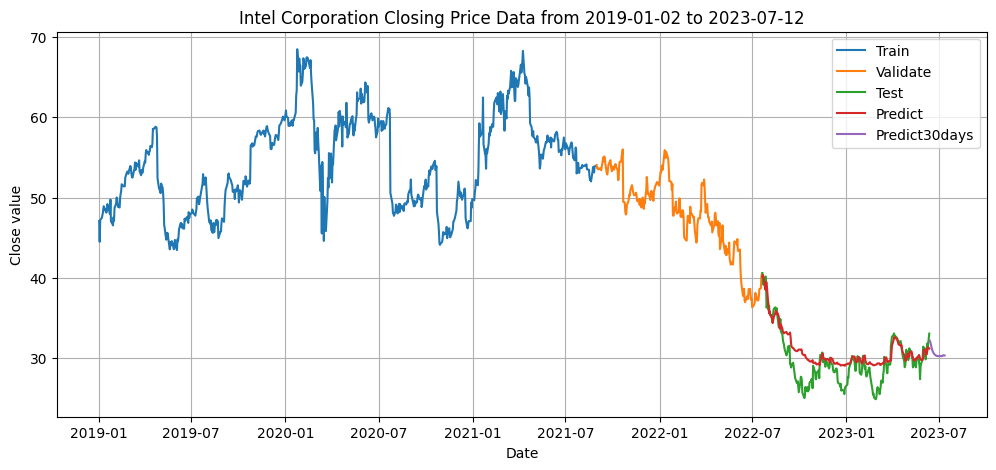

In [22]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size : ], loaded_best_y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Intel Corporation Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_622_INTC.png')
plt.show()